In [ ]:
#pneumonia

In [ ]:
import os
os.environ["KAGGLE_USERNAME"] = "anushka1812garg"
os.environ["KAGGLE_KEY"] = "10800c044e4e8747eb3b68c5b2a2ceaa"
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:02<00:00, 41.9MB/s]
100% 2.29G/2.29G [01:02<00:00, 39.4MB/s]


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import os
from pathlib import Path
from time import perf_counter
import numpy as np
import cv2
from IPython.display import Markdown, display
%matplotlib inline

In [ ]:
!nvidia-smi

Mon Nov 13 03:57:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python -m pip freeze


absl-py==1.4.0
aiohttp==3.8.6
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.13.1
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.13.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.0
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.7.22
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.7
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.3
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==41.0.5
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.2
cvxpy==1.3.2
cycler==0.12.1
cy

In [ ]:
print(Path.__version__)

AttributeError: ignored

In [ ]:
 !unzip chest-xray-pneumonia.zip

In [ ]:
len(os.listdir("chest_xray/train/NORMAL"))

1341

In [ ]:
len(os.listdir("chest_xray/train/PNEUMONIA"))

3875

In [ ]:
len(os.listdir("chest_xray/test/NORMAL"))

234

In [ ]:
len(os.listdir("chest_xray/test/PNEUMONIA"))

390

In [ ]:
len(os.listdir("chest_xray/val/NORMAL"))

8

In [ ]:
len(os.listdir("chest_xray/val/PNEUMONIA"))

8

In [ ]:
dir_ = Path('/content/chest_xray/train')
train_file_paths = list(dir_.glob(r'**/*.jpeg'))

dir_ = Path('/content/chest_xray/test')
test_file_paths = list(dir_.glob(r'**/*.jpeg'))

dir_ = Path('/content/chest_xray/val')
val_file_paths = list(dir_.glob(r'**/*.jpeg'))

In [ ]:
import pandas as pd
from typing import List
from pathlib import Path

def create_image_dataframe(filepaths: List[str]) -> pd.DataFrame:
    """Creates a DataFrame with filepaths and corresponding labels.

    Args:
        filepaths (List[str]): A list of filepaths.

    Returns:
        pd.DataFrame: A DataFrame containing the filepaths and labels.
    """

    labels = [Path(filepath).parent.name for filepath in filepaths]

    filepath_series = pd.Series(filepaths, name='Filepath').astype(str)
    labels_series = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath_series, labels_series], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    return df

train_df = create_image_dataframe(train_file_paths)
val_df = create_image_dataframe(val_file_paths)
# Combine train_df and val_df
train_df = pd.concat([train_df,val_df]).reset_index(drop = True)
test_df = create_image_dataframe(test_file_paths)


print(f'Number of pictures in the training set: {train_df.shape[0]}')
print(f'Number of pictures in the test set: {test_df.shape[0]}')
print(f'Number of pictures in the validation set: {val_df.shape[0]}\n')


print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures in the training set: 5232
Number of pictures in the test set: 624
Number of pictures in the validation set: 16

Number of different labels: 2

Labels: ['PNEUMONIA' 'NORMAL']


Filepath      Label
0  /content/chest_xray/train/PNEUMONIA/person811_...  PNEUMONIA
1  /content/chest_xray/train/PNEUMONIA/person563_...  PNEUMONIA
2  /content/chest_xray/train/NORMAL/NORMAL2-IM-05...     NORMAL
3  /content/chest_xray/train/PNEUMONIA/person593_...  PNEUMONIA
4  /content/chest_xray/train/PNEUMONIA/person1328...  PNEUMONIA

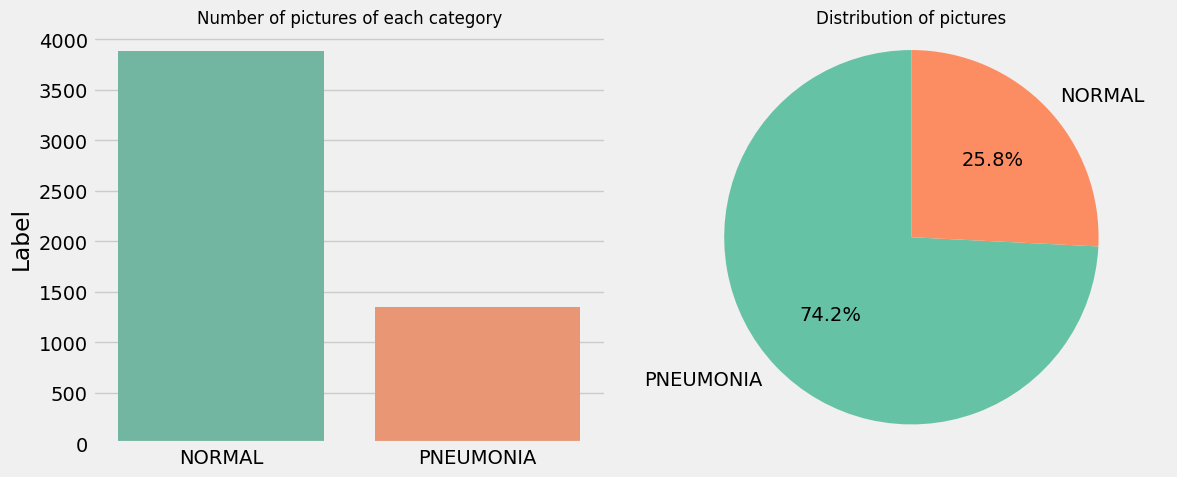

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_category_distribution(df, save_path):
    """Plots and saves a bar plot and a pie chart for the category distribution in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the category data.
        save_path (str): The directory to save the generated images.
    """

    # Display the number of pictures of each category in the DataFrame
    vc = df['Label'].value_counts()

    # Plotting the bar chart
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(x=sorted(vc.index), y=vc, palette="Set2")
    plt.title("Number of pictures of each category", fontsize=12)

    # Saving the bar plot
    bar_plot_path = os.path.join(save_path, 'category_distribution_bar.png')
    plt.savefig(bar_plot_path)

    # Plotting the pie chart
    plt.subplot(1, 2, 2)
    plt.pie(vc, labels=vc.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
    plt.title("Distribution of pictures", fontsize=12)
    plt.axis('equal')

    # Saving the pie chart
    pie_chart_path = os.path.join(save_path, 'category_distribution_pie.png')
    plt.savefig(pie_chart_path)

    plt.tight_layout()
    plt.show()

# Example usage
plot_category_distribution(train_df, '/content/chest_xray/train')

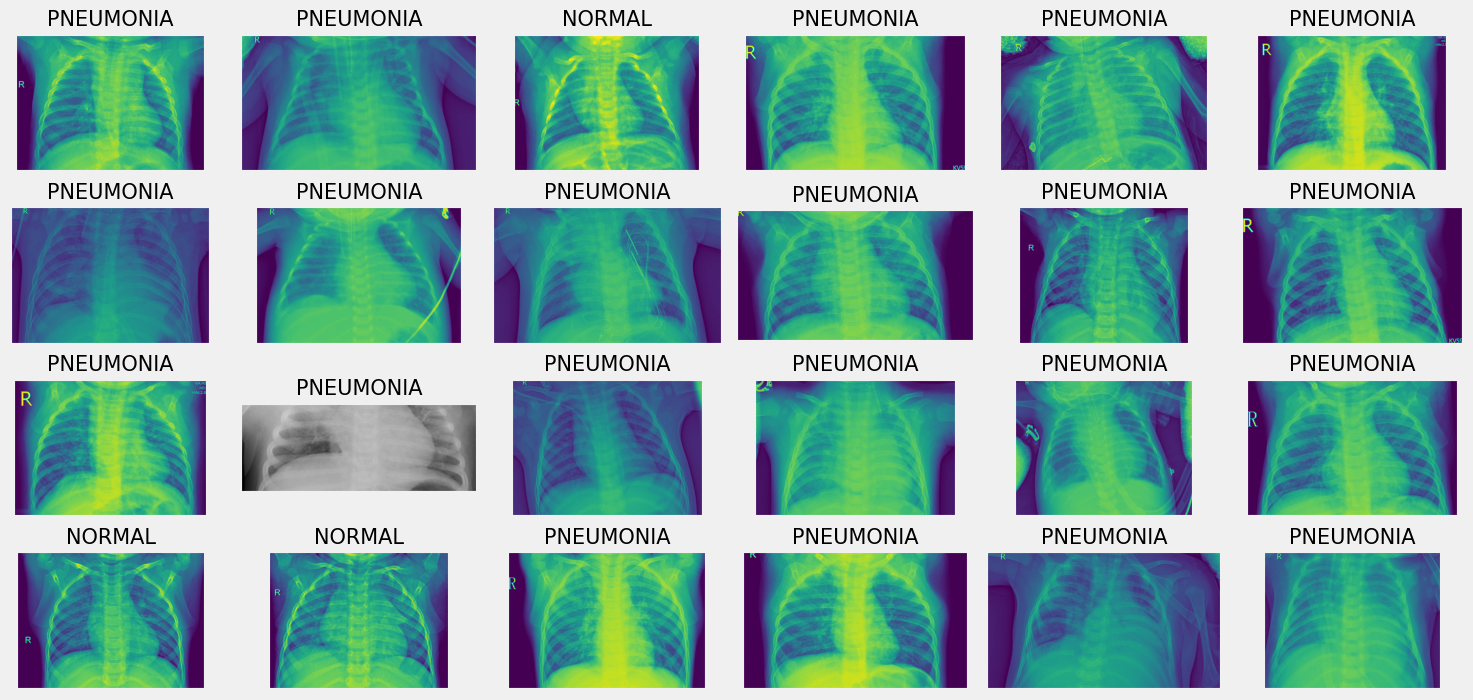

In [ ]:
def display_images(df, nrows, ncols, figsize, save_path=None):
    """Displays images from the dataset on subplots and saves the generated image if save_path is provided.

    Args:
        df (pd.DataFrame): The DataFrame containing the image filepaths and labels.
        nrows (int): The number of rows of subplots.
        ncols (int): The number of columns of subplots.
        figsize (tuple): The figure size (width, height) in inches.
        save_path (str, optional): The directory to save the generated image. Defaults to None.
    """

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Filepath[i]))
        ax.set_title(df.Label[i], fontsize=15)

    plt.tight_layout(pad=0.5)

    # Saving the generated image if save_path is provided
    if save_path is not None:
        save_file_path = os.path.join(save_path, 'image_display.png')
        plt.savefig(save_file_path)

    plt.show()

# Example usage
display_images(train_df, nrows=4, ncols=6, figsize=(15, 7), save_path='/content/chest_xray/train')

In [ ]:
def create_gen():
    """
    Create image data generators for training, validation, and testing.

    Returns:
        train_generator (ImageDataGenerator): Image data generator for training data.
        test_generator (ImageDataGenerator): Image data generator for testing data.
        train_images (DirectoryIterator): Iterator for training images.
        val_images (DirectoryIterator): Iterator for validation images.
        test_images (DirectoryIterator): Iterator for testing images.
    """
    # Define common image data generator arguments
    common_args = {
        'preprocessing_function': tf.keras.applications.mobilenet_v2.preprocess_input,
        'class_mode': 'categorical',
        'batch_size': 32,
        'seed': 0,
        'target_size': (224, 224)
    }

    # Define augmentation arguments
    augmentation_args = {
        'rotation_range': 30,
        'zoom_range': 0.15,
        'width_shift_range': 0.2,
        'height_shift_range': 0.2,
        'shear_range': 0.15,
        'horizontal_flip': True,
        'fill_mode': 'nearest'
    }

    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.1,
        **augmentation_args
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

    # Flow from DataFrame arguments
    flow_args = {
        'x_col': 'Filepath',
        'y_col': 'Label',
        'color_mode': 'rgb'
    }

    # Flow from DataFrame for training images
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        subset='training',
        **common_args,
        **flow_args
    )

    # Flow from DataFrame for validation images
    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        shuffle=False,
        subset='validation',
        **common_args,
        **flow_args
    )

    # Flow from DataFrame for test images
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        shuffle=False,
        **common_args,
        **flow_args
    )

    return train_generator, test_generator, train_images, val_images, test_images

In [ ]:
def create_model(model_class):
    """
    Create a custom model based on a model class.

    Args:
        model_class (tf.keras.Model): Model class.

    Returns:
        model (tf.keras.Model): Custom model.
    """
    # Load the pretrained model
    base_model = model_class(weights='imagenet', include_top=False, pooling='avg')
    base_model.trainable = False

    # Add custom layers on top of the base model
    x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create the custom model
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
models = {
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():

    # Get the model
    m = create_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=2,verbose=0)

    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 4709 validated image filenames belonging to 2 classes.
Found 523 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.




9406464/9406464 [==============================] - 1s 0us/step
MobileNetV2          trained in 250.81 sec
71686520/71686520 [==============================] - 3s 0us/step
EfficientNetB7       trained in 257.31 sec
87910968/87910968 [==============================] - 4s 0us/step
InceptionV3          trained in 279.5 sec
171446536/171446536 [==============================] - 7s 0us/step
ResNet101            trained in 251.55 sec
94765736/94765736 [==============================] - 4s 0us/step
ResNet50             trained in 232.49 sec
80134624/80134624 [==============================] - 4s 0us/step
VGG19                trained in 235.71 sec
83683744/83683744 [==============================] - 4s 0us/step
Xception             trained in 231.01 sec


In [ ]:
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)


    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)

20/20 [==============================] - 7s 301ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred, axis=1)

    # Map the label
    labels = train_images.class_indices
    labels = dict((v, k) for k, v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)

    # Calculate accuracy
    acc = accuracy_score(y_test, pred)
    models[name]['acc'] = round(acc, 4)

    # Calculate precision
    precision = precision_score(y_test, pred, average='weighted')
    models[name]['precision'] = round(precision, 4)

    # Calculate recall
    recall = recall_score(y_test, pred, average='weighted')
    models[name]['recall'] = round(recall, 4)

    # Calculate F1 score
    f1 = f1_score(y_test, pred, average='weighted')
    models[name]['f1'] = round(f1, 4)

models

20/20 [==============================] - 5s 252ms/step


{'MobileNetV2': {'model': <keras.src.engine.functional.Functional at 0x7ce2807f8d60>,
  'perf': 250.81,
  'val_acc': [0.8738, 0.9159],
  'acc': 0.7516,
  'precision': 0.7471,
  'recall': 0.7516,
  'f1': 0.7462},
 'EfficientNetB7': {'model': <keras.src.engine.functional.Functional at 0x7ce296e21cc0>,
  'perf': 257.31,
  'val_acc': [0.9331, 0.9522],
  'acc': 0.8654,
  'precision': 0.8823,
  'recall': 0.8654,
  'f1': 0.8673},
 'InceptionV3': {'model': <keras.src.engine.functional.Functional at 0x7ce1f28c3370>,
  'perf': 279.5,
  'val_acc': [0.7572, 0.8719],
  'acc': 0.8462,
  'precision': 0.8586,
  'recall': 0.8462,
  'f1': 0.8387},
 'ResNet101': {'model': <keras.src.engine.functional.Functional at 0x7ce1dc322590>,
  'perf': 251.55,
  'val_acc': [0.9273, 0.9465],
  'acc': 0.9054,
  'precision': 0.9051,
  'recall': 0.9054,
  'f1': 0.905},
 'ResNet50': {'model': <keras.src.engine.functional.Functional at 0x7ce1b031bbe0>,
  'perf': 232.49,
  'val_acc': [0.9446, 0.9522],
  'acc': 0.9119,
  'p

In [ ]:
data={
        'model_name':['CNN model 1', 'CNN model 2', 'MobileNetV2', 'EfficientNetB7', 'InceptionV3', 'ResNet101', 'ResNet50', 'VGG19', 'Xception'],
        'accuracy':[0.9189, 0.9070, 0.7516, 0.8654, 0.8462, 0.9054, 0.9119, 0.8766, 0.8317 ],
        'precision':[0.8723, 0.8760, 0.7471, 0.8823, 0.8586, 0.9051, 0.9117, 0.8759, 0.8401 ],
        'recall':[0.8441, 0.8760, 0.7516, 0.8654, 0.8462, 0.9054, 0.9119, 0.8766, 0.8317 ],
        'f1_score':[0.9185, 0.8760, 0.7462, 0.8673, 0.8387, 0.905, 0.9117,0.8757, 0.8336 ]
    }
table=pd.DataFrame(data)
table

model_name  accuracy  precision  recall  f1_score
0     CNN model 1    0.9189     0.8723  0.8441    0.9185
1     CNN model 2    0.9070     0.8760  0.8760    0.8760
2     MobileNetV2    0.7516     0.7471  0.7516    0.7462
3  EfficientNetB7    0.8654     0.8823  0.8654    0.8673
4     InceptionV3    0.8462     0.8586  0.8462    0.8387
5       ResNet101    0.9054     0.9051  0.9054    0.9050
6        ResNet50    0.9119     0.9117  0.9119    0.9117
7           VGG19    0.8766     0.8759  0.8766    0.8757
8        Xception    0.8317     0.8401  0.8317    0.8336

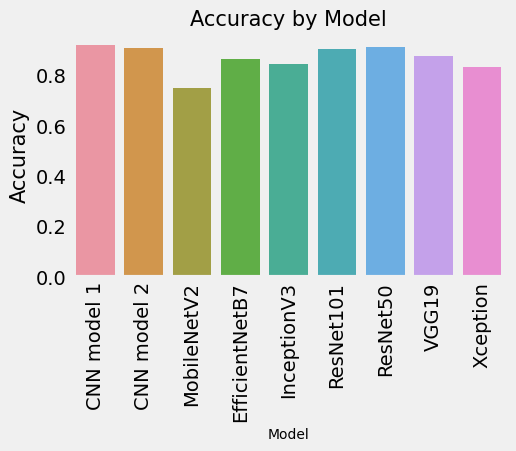

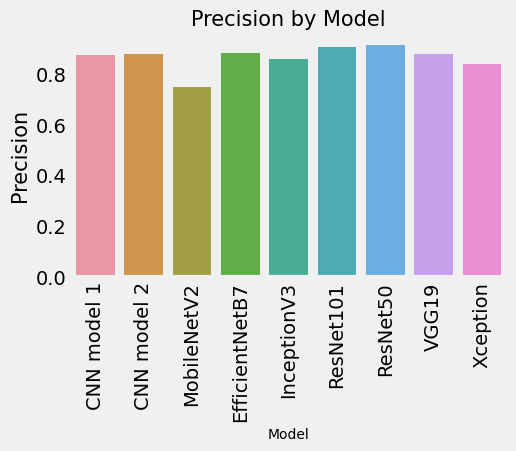

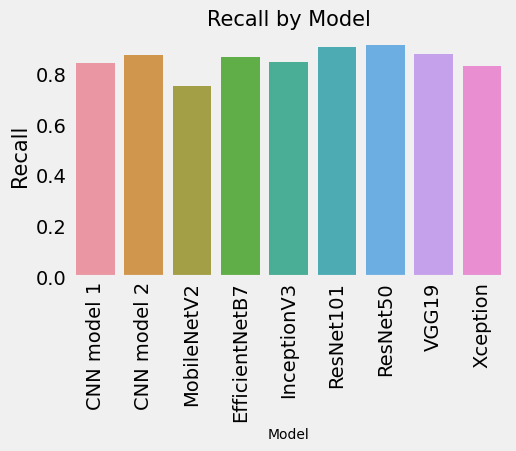

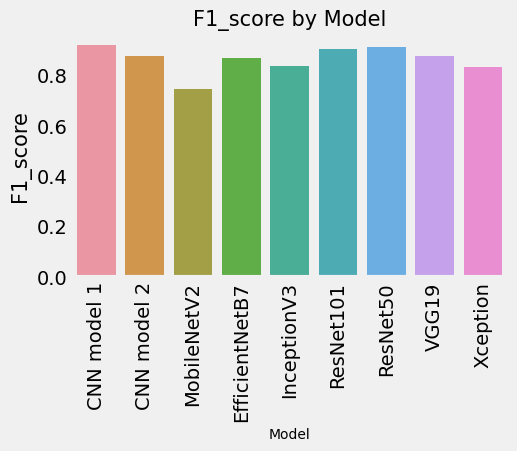


The best model based on accuracy is: CNN model 1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from the given data
data = {
    'model_name':['CNN model 1', 'CNN model 2', 'MobileNetV2', 'EfficientNetB7', 'InceptionV3', 'ResNet101', 'ResNet50', 'VGG19', 'Xception'],
    'accuracy':[0.9189, 0.9070, 0.7516, 0.8654, 0.8462, 0.9054, 0.9119, 0.8766, 0.8317 ],
    'precision':[0.8723, 0.8760, 0.7471, 0.8823, 0.8586, 0.9051, 0.9117, 0.8759, 0.8401 ],
    'recall':[0.8441, 0.8760, 0.7516, 0.8654, 0.8462, 0.9054, 0.9119, 0.8766, 0.8317 ],
    'f1_score':[0.9185, 0.8760, 0.7462, 0.8673, 0.8387, 0.905, 0.9117,0.8757, 0.8336 ]
}
table = pd.DataFrame(data)

# Create separate plots for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics:
    plt.figure(figsize=(5, 3))
    #plt.bar(table['model_name'], table[metric])
    sns.barplot(x = table['model_name'], y = table[metric])
    plt.title(f'{metric.capitalize()} by Model',fontsize = 15)
    plt.xlabel('Model',fontsize = 10)
    plt.ylabel(metric.capitalize(), fontsize = 15)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()
    print()

# Suggest the best model based on a specific metric (e.g., accuracy)
best_model = table[table['accuracy'] == table['accuracy'].max()]['model_name'].values[0]
print(f"The best model based on accuracy is: {best_model}")


In [ ]:
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy (test set)','Training time (sec)'])
df_results.sort_values(by='accuracy (test set)', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
# Save df_results to a text file
df_results.to_csv('/content/chest_xray/models_results.txt', index=False, sep='\t')
df_results

model  val_accuracy  accuracy (test set)  Training time (sec)
0           VGG19        0.9082               0.8846               143.35
1       ResNet101        0.9560               0.8798               118.54
2        ResNet50        0.9465               0.8734               109.75
3  EfficientNetB7        0.9560               0.8638               128.70
4        Xception        0.8375               0.8269               111.77
5     InceptionV3        0.8681               0.8237               108.91
6     MobileNetV2        0.9197               0.6859               115.59

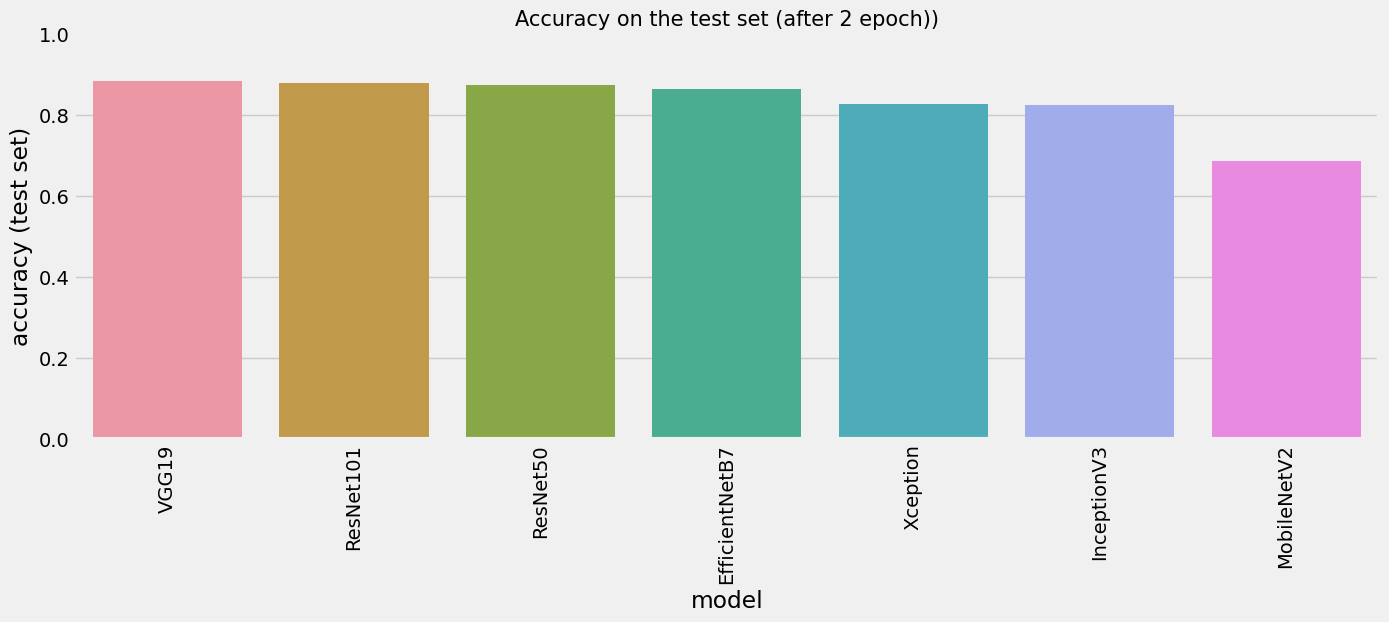

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy (test set)', data = df_results)
plt.title('Accuracy on the test set (after 2 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

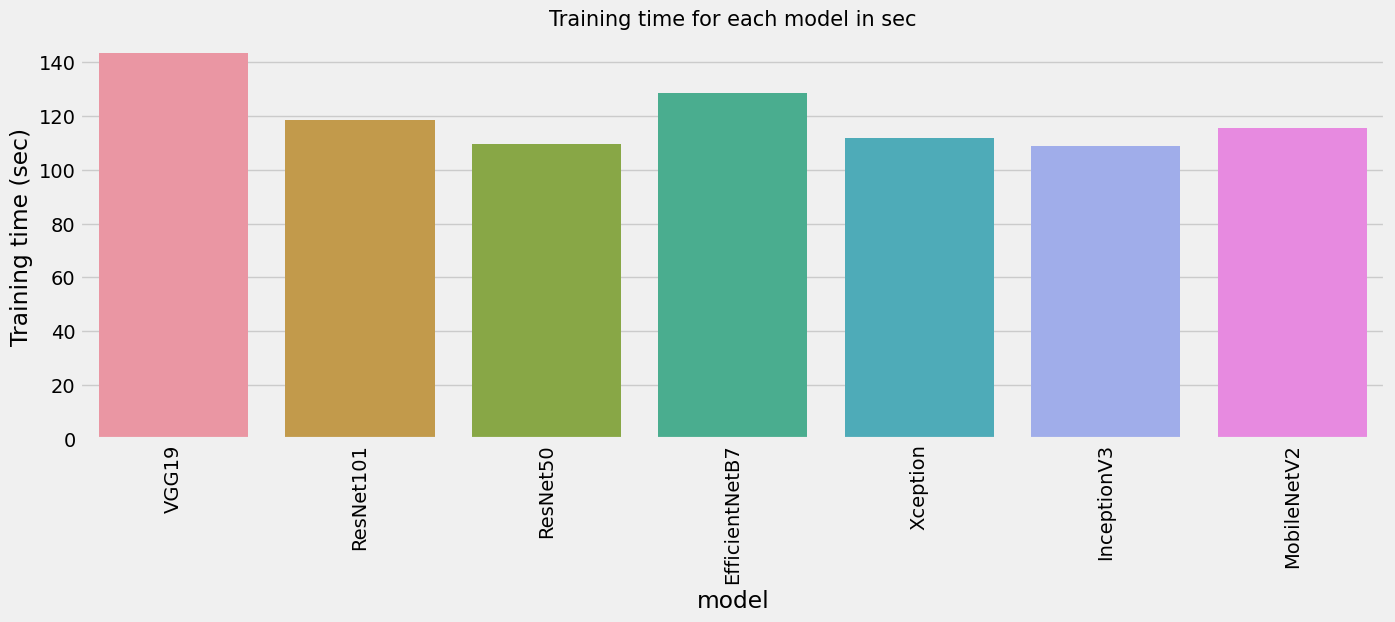

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
acc = df_results.iloc[0]['accuracy (test set)']
best_model = df_results.iloc[0]['model']
print(f'Best model: {best_model}')
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Best model: VGG19
Accuracy on the test set: 88.46%


In [ ]:
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'best_model.h5')
models[best_model]['model'].save(save_path)
print(f'Best model saved at: {save_path}')

Best model saved at: saved_models/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pred = models[best_model]['model'].predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
models[name]['acc'] = round(acc,4)

20/20 [==============================] - 6s 294ms/step


Confusion matrix saved as /content/chest_xray/confusion_matrix.png


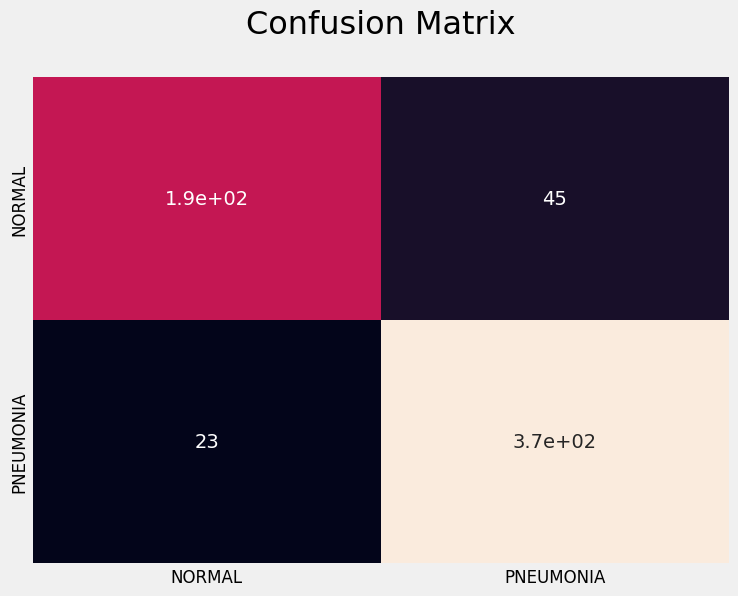

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_true, y_pred, save_path=None):
    """
    Display a confusion matrix and save it as an image file if the save_path is not None.

    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        save_path (str or None): Path to save the confusion matrix image. If None, the image will not be saved.

    Returns:
        None
    """
    cf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)), cbar=False)
    plt.title('Confusion Matrix\n', fontsize=23)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    if save_path is not None:
        plt.savefig(save_path)
        print(f"Confusion matrix saved as {save_path}")
    else:
        plt.show()
# Assuming you have the y_test and pred variables defined
save_path = "/content/chest_xray/confusion_matrix.png"  # Set the desired save path or set it to None to only display the matrix

display_confusion_matrix(y_test, pred, save_path)

In [ ]:
from sklearn.metrics import classification_report

def save_classification_report(y_true, y_pred, save_path=None):
    """
    Print the classification report and save it as a text file if the save_path is not None.

    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        save_path (str or None): Path to save the classification report. If None, the report will not be saved.

    Returns:
        None
    """
    report = classification_report(y_true, y_pred)

    print(report)

    if save_path is not None:
        with open(save_path, "w") as file:
            file.write(report)
        print(f"Classification report saved as {save_path}")


# Assuming you have the y_test and pred variables defined
save_path = "/content/chest_xray/classification_report.txt"  # Set the desired save path or set it to None to only print the report

save_classification_report(y_test, pred, save_path)

              precision    recall  f1-score   support

      NORMAL       0.89      0.81      0.85       234
   PNEUMONIA       0.89      0.94      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624

Classification report saved as /content/chest_xray/classification_report.txt


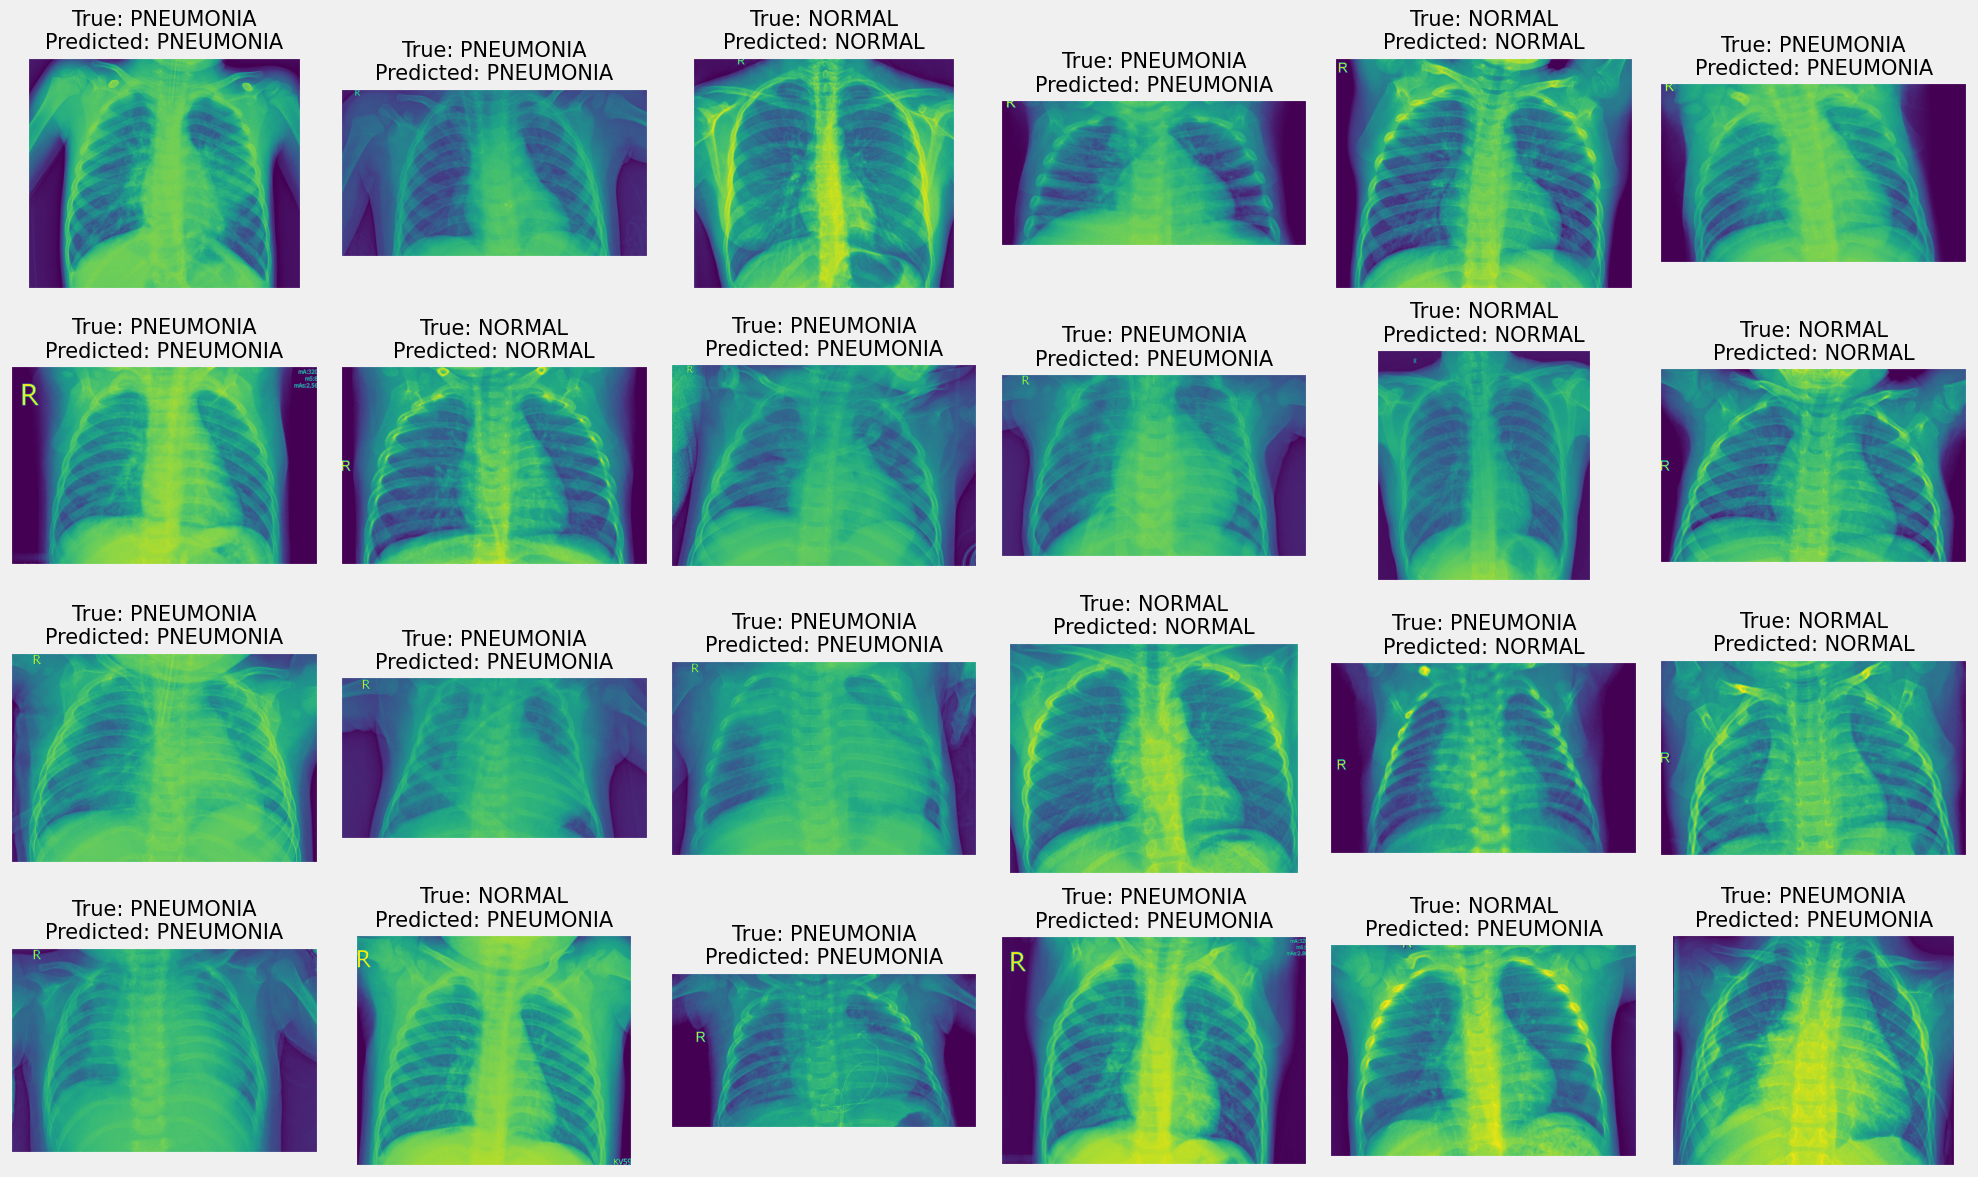

In [ ]:
import matplotlib.pyplot as plt

def display_predicted_images(test_df, pred):
    """
    Display pictures of the test dataset with their True and Predicted labels.

    Args:
        test_df (pandas.DataFrame): DataFrame containing the test dataset.
        pred (list): List of predicted labels.

    Returns:
        None
    """
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
        ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}", fontsize=15)

    plt.tight_layout()
    plt.show()

display_predicted_images(test_df, pred)

In [ ]:
len(os.listdir("chest_xray/train/PNEUMONIA"))

3875

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
path = "chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
img = cv2.imread(path)

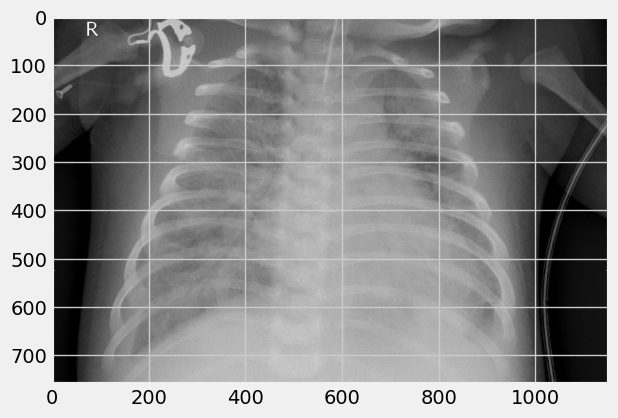

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
img.shape

(760, 1152, 3)

In [ ]:
train = get_training_data('/content/chest_xray/train')
test = get_training_data('/content/chest_xray/test')
val = get_training_data('/content/chest_xray/val')

<ipython-input-6-8f9b9952bc9d>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
pnenumonia = 0
normal = 0

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1

print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


PNEUMONIA


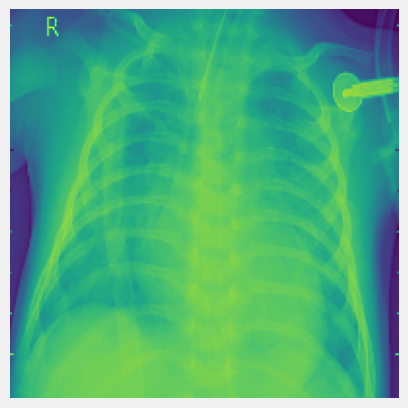

In [ ]:
plt.imshow(train[1][0], cmap='viridis')
plt.axis('off')
print(labels[train[1][1]])

In [ ]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)

for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [ ]:
# good for balancing out disproportions in the dataset
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

In [ ]:
# model = Sequential()
# model.add(Conv2D(1024, (3, 3), input_shape=X_train.shape[1:], padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(BatchNormalization(axis=1))

# model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(BatchNormalization(axis=1))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(BatchNormalization(axis=1))

# model.add(Conv2D(16, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(BatchNormalization(axis=1))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dropout(0.5))
# model.add(Dense(64))
# model.add(Activation('relu'))

# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
# adam = Adam(learning_rate=0.0001)
# model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=X_train.shape[1:], padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 activation_7 (Activation)   (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        9248      
                                                                 
 activation_8 (Activation)   (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 activation_7 (Activation)   (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        9248      
                                                                 
 activation_8 (Activation)   (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                 

In [ ]:
#history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=30)

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
375/375 [==============================] - 19s 45ms/step - loss: 0.5444 - acc: 0.7382 - val_loss: 0.4103 - val_acc: 0.7588
Epoch 2/15
375/375 [==============================] - 16s 42ms/step - loss: 0.3902 - acc: 0.7958 - val_loss: 0.3037 - val_acc: 0.8570
Epoch 3/15
375/375 [==============================] - 16s 41ms/step - loss: 0.3622 - acc: 0.8369 - val_loss: 0.2786 - val_acc: 0.8837
Epoch 4/15
375/375 [==============================] - 18s 47ms/step - loss: 0.3415 - acc: 0.8497 - val_loss: 0.3010 - val_acc: 0.8495
Epoch 5/15
375/375 [==============================] - 17s 44ms/step - loss: 0.3177 - acc: 0.8671 - val_loss: 0.2498 - val_acc: 0.8869
Epoch 6/15
375/375 [==============================] - 16s 42ms/step - loss: 0.3224 - acc: 0.8599 - val_loss: 0.2420 - val_acc: 0.9029
Epoch 7/15
375/375 [==============================] - 16s 42ms/step - loss: 0.3148 - acc: 0.8588 - val_loss: 0.2248 - val_acc: 0.9039
Epoch 8/15
375/375 [==============================] - 16s 43ms

In [ ]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 1s 15ms/step - loss: 0.2258 - acc: 0.9121


[0.22577396035194397, 0.9121160507202148]

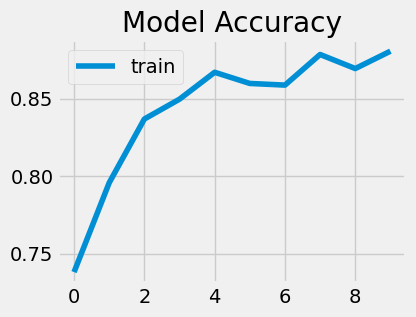

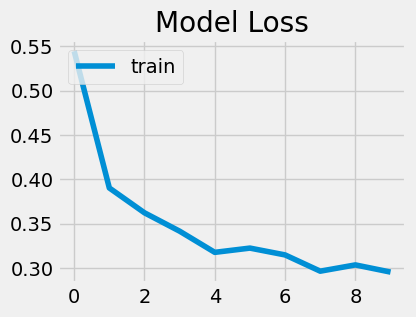

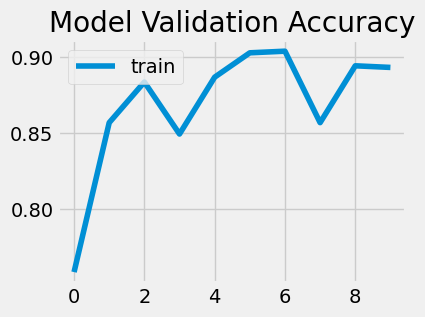

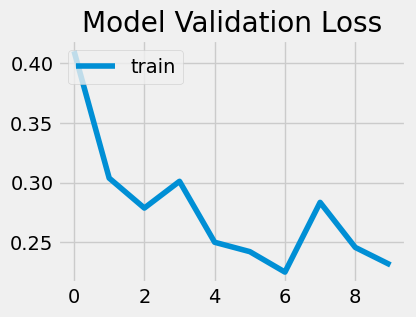

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 [==============================] - 2s 16ms/step


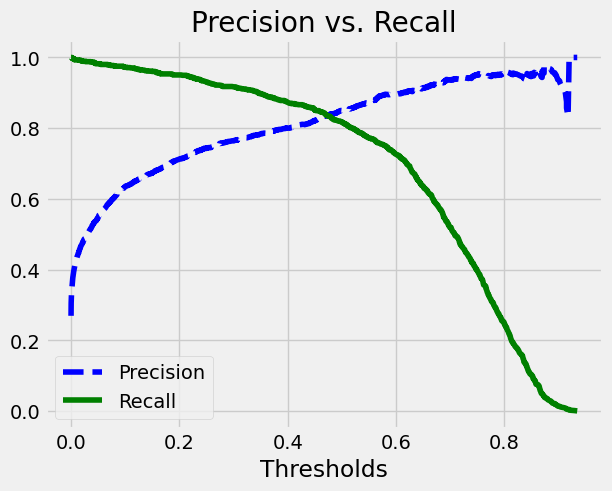

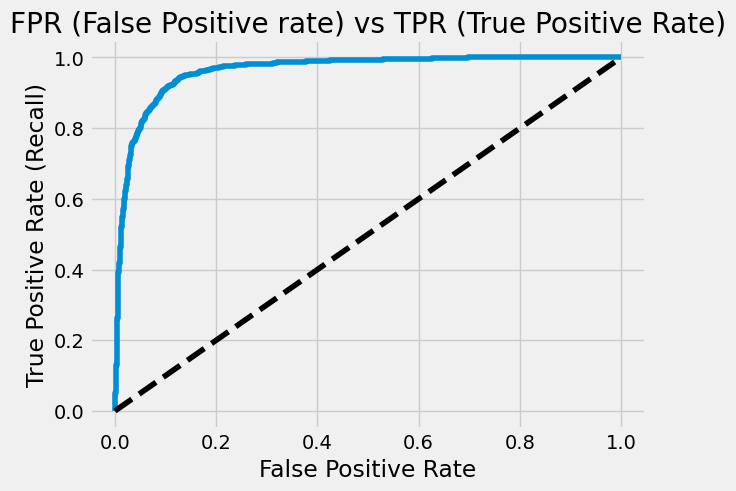

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()

plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [ ]:
predictions = model.predict(X_test)

37/37 [==============================] - 0s 8ms/step


In [ ]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print('F1 score on testing set:', f1_score(binary_predictions, y_test, average='weighted'))

Accuracy on testing set: 0.9189419795221843
Precision on testing set: 0.8723404255319149
Recall on testing set: 0.8441176470588235
F1 score on testing set: 0.9185417439044846
